## Coadd using the original code written in Python way

In [2]:
import os, sys

from importlib import reload

import numpy as np
import numpy.linalg as la
from numpy import fft

import matplotlib as mpl
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import AsinhStretch
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.visualization import astropy_mpl_style
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData

from photutils.detection import DAOStarFinder
from photutils.psf import EPSFBuilder
from photutils.psf import extract_stars
from photutils.centroids import centroid_com

from scipy.ndimage import shift

stretch = AsinhStretch()

plt.style.use(astropy_mpl_style)
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

%matplotlib inline
%config InlineBackend.figure_format='retina'

import testing functions from `../src/`

In [10]:
sys.path.append('..')

import dither.utils as dutils
import dither.wrapper as wrapper
import dither.updated as updated

### Prepare Data

#### Read cutout paths

Naming convention of single images:

```
           "xxx_path"          
|-----------------------------|
/path/to/the/file/filename.fits
|----------------|------------|
    "xxx_dir"      "xxx_name"  
                               
xxx_data = array([[...]])      
```


Naming convention of lists:
```
xxx_paths = [xxx_path, xxx_path, ...]
xxx_names = [xxx_name, xxx_name, ...]
xxx_atlas = [xxx_data, xxx_data, ...]
```

In [11]:
cutout_dir = '/quasar/yichenliu/cutout_f250m'
cutout_paths = []
cutout_names = os.listdir(cutout_dir)
for cutout_name in cutout_names: 
    cutout_path = os.path.join(cutout_dir, cutout_name)
    cutout_paths.append(cutout_path)
cutout_paths.sort()

cutout_paths

['/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00001_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00002_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00003_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00004_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00005_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00006_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00007_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00008_nrcblong_cal_bsub_aligned_cutout.fits',
 '/quasar/yichenliu/cutout_f250m/jw01764001001_02101_00009_nrcblong_cal_bsub_aligned_cutout.fits']

#### Load images

In [12]:
orig_atlas = []
for cutout_path in cutout_paths: 
    with fits.open(cutout_path) as hdul: 
        data = hdul[1].data
        orig_atlas.append(data)

#### Get the offsets

Find the brightest pixel near the center

In [13]:
brightest_xys = []
for data in orig_atlas: 
    xy = dutils.get_brightest_pixel(data, 50, 100, 50, 100) # some random limits
    brightest_xys.append(xy)
brightest_xys = np.array(brightest_xys)

brightest_xys

array([[76, 77],
       [80, 77],
       [78, 80],
       [77, 76],
       [77, 75],
       [77, 76],
       [77, 76],
       [76, 76],
       [77, 76]])

pad the images to align its centers

In [14]:
pad = dutils.calculate_padding_radius(brightest_xys)

aligned_atlas = []
for i in range(9):
    data = orig_atlas[i]
    brightest_xy = brightest_xys[i]
    aligned_data = dutils.pad_image_with_centroid(data, pad, brightest_xy)
    aligned_atlas.append(aligned_data)

Calculate the centroids by averaging up the pixels within the central area using `centroid_com` in `Photutils`

In [15]:
cx, cy = dutils.get_pixel_center_from_array(orig_atlas[0])
r = 5

centroids = []
for i in range(9): 
    data = aligned_atlas[i]
    centroid = dutils.get_centroids_using_centroid_com(data, cx, cy, r)
    centroids.append(centroid)
centroids = np.array(centroids)
centroids -= [cx, cy]
centroids

array([[-0.038, -0.44 ],
       [-0.408, -0.225],
       [ 0.189, -0.048],
       [-0.603, -0.125],
       [-0.091,  0.093],
       [-0.453,  0.342],
       [-0.303,  0.24 ],
       [ 0.091, -0.448],
       [-0.224, -0.289]])

A more proper way is to perform a source detection using `DAOStarFinder` in `Photusils`. These two methods have on average 6% difference. 

In [16]:
centroids = []

for i in range(9): 
    data = aligned_atlas[i]
    centroid = dutils.get_centroids_using_DAOStarFinder(data, cx, cy)
    centroids.append(centroid)
centroids = np.array(centroids)
centroids -= [cx, cy]

centroids

array([[ 0.096, -0.456],
       [-0.311, -0.152],
       [ 0.395,  0.036],
       [-0.559, -0.082],
       [ 0.077,  0.149],
       [-0.315,  0.445],
       [-0.2  ,  0.352],
       [ 0.254, -0.457],
       [-0.114, -0.237]])

Visually check the center

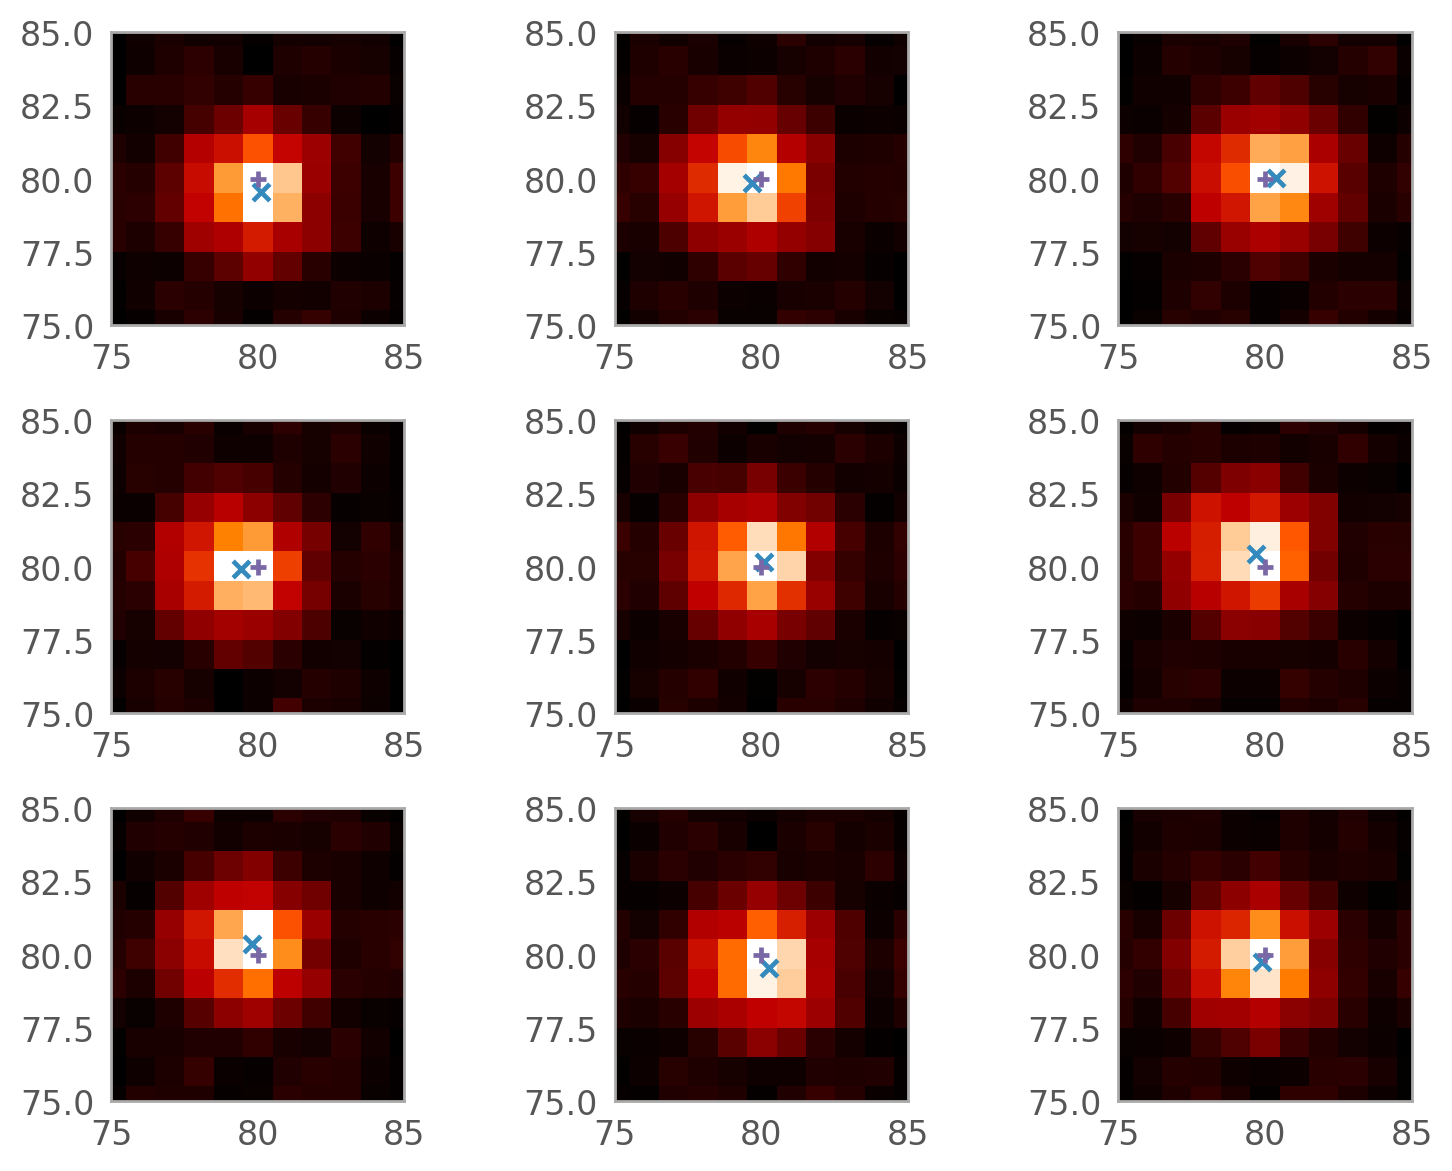

In [17]:
fig, axs = plt.subplots(3, 3)
axs = axs.flat
for i in range(9): 
    data = aligned_atlas[i]
    
    qso_center = [cx+centroids[i, 0], cx+centroids[i, 1]]
    img_center = [cx, cy]
    axs[i].imshow(np.arcsinh(data), vmin=0, vmax=5)
    axs[i].scatter(*qso_center, marker='x')
    axs[i].scatter(*img_center, marker='+')
    axs[i].set_xlim(cx-5, cx+5)
    axs[i].set_ylim(cy-5, cy+5)
    axs[i].grid(False)
plt.tight_layout()
plt.show()

#### Mask out cosmic rays

The AGN is excluded by counting the number of connected pixels

In [18]:
masks = []

for i in range(9):
    data = aligned_atlas[i]
    mask = dutils.get_cosmic_ray_mask_without_AGN(data, kernel_size=3, sigma_threshold=40, max_connected_pixels=16)
    masks.append(mask)

Mask them out by setting them to 0 because the image is already background subtracted

In [19]:
aligned_atlas_masked = []
for i in range(9): 
    data_masked = aligned_atlas[i].copy()
    mask = masks[i]
    data_masked[mask] = 0
    aligned_atlas_masked.append(data_masked)

Visually check the mask

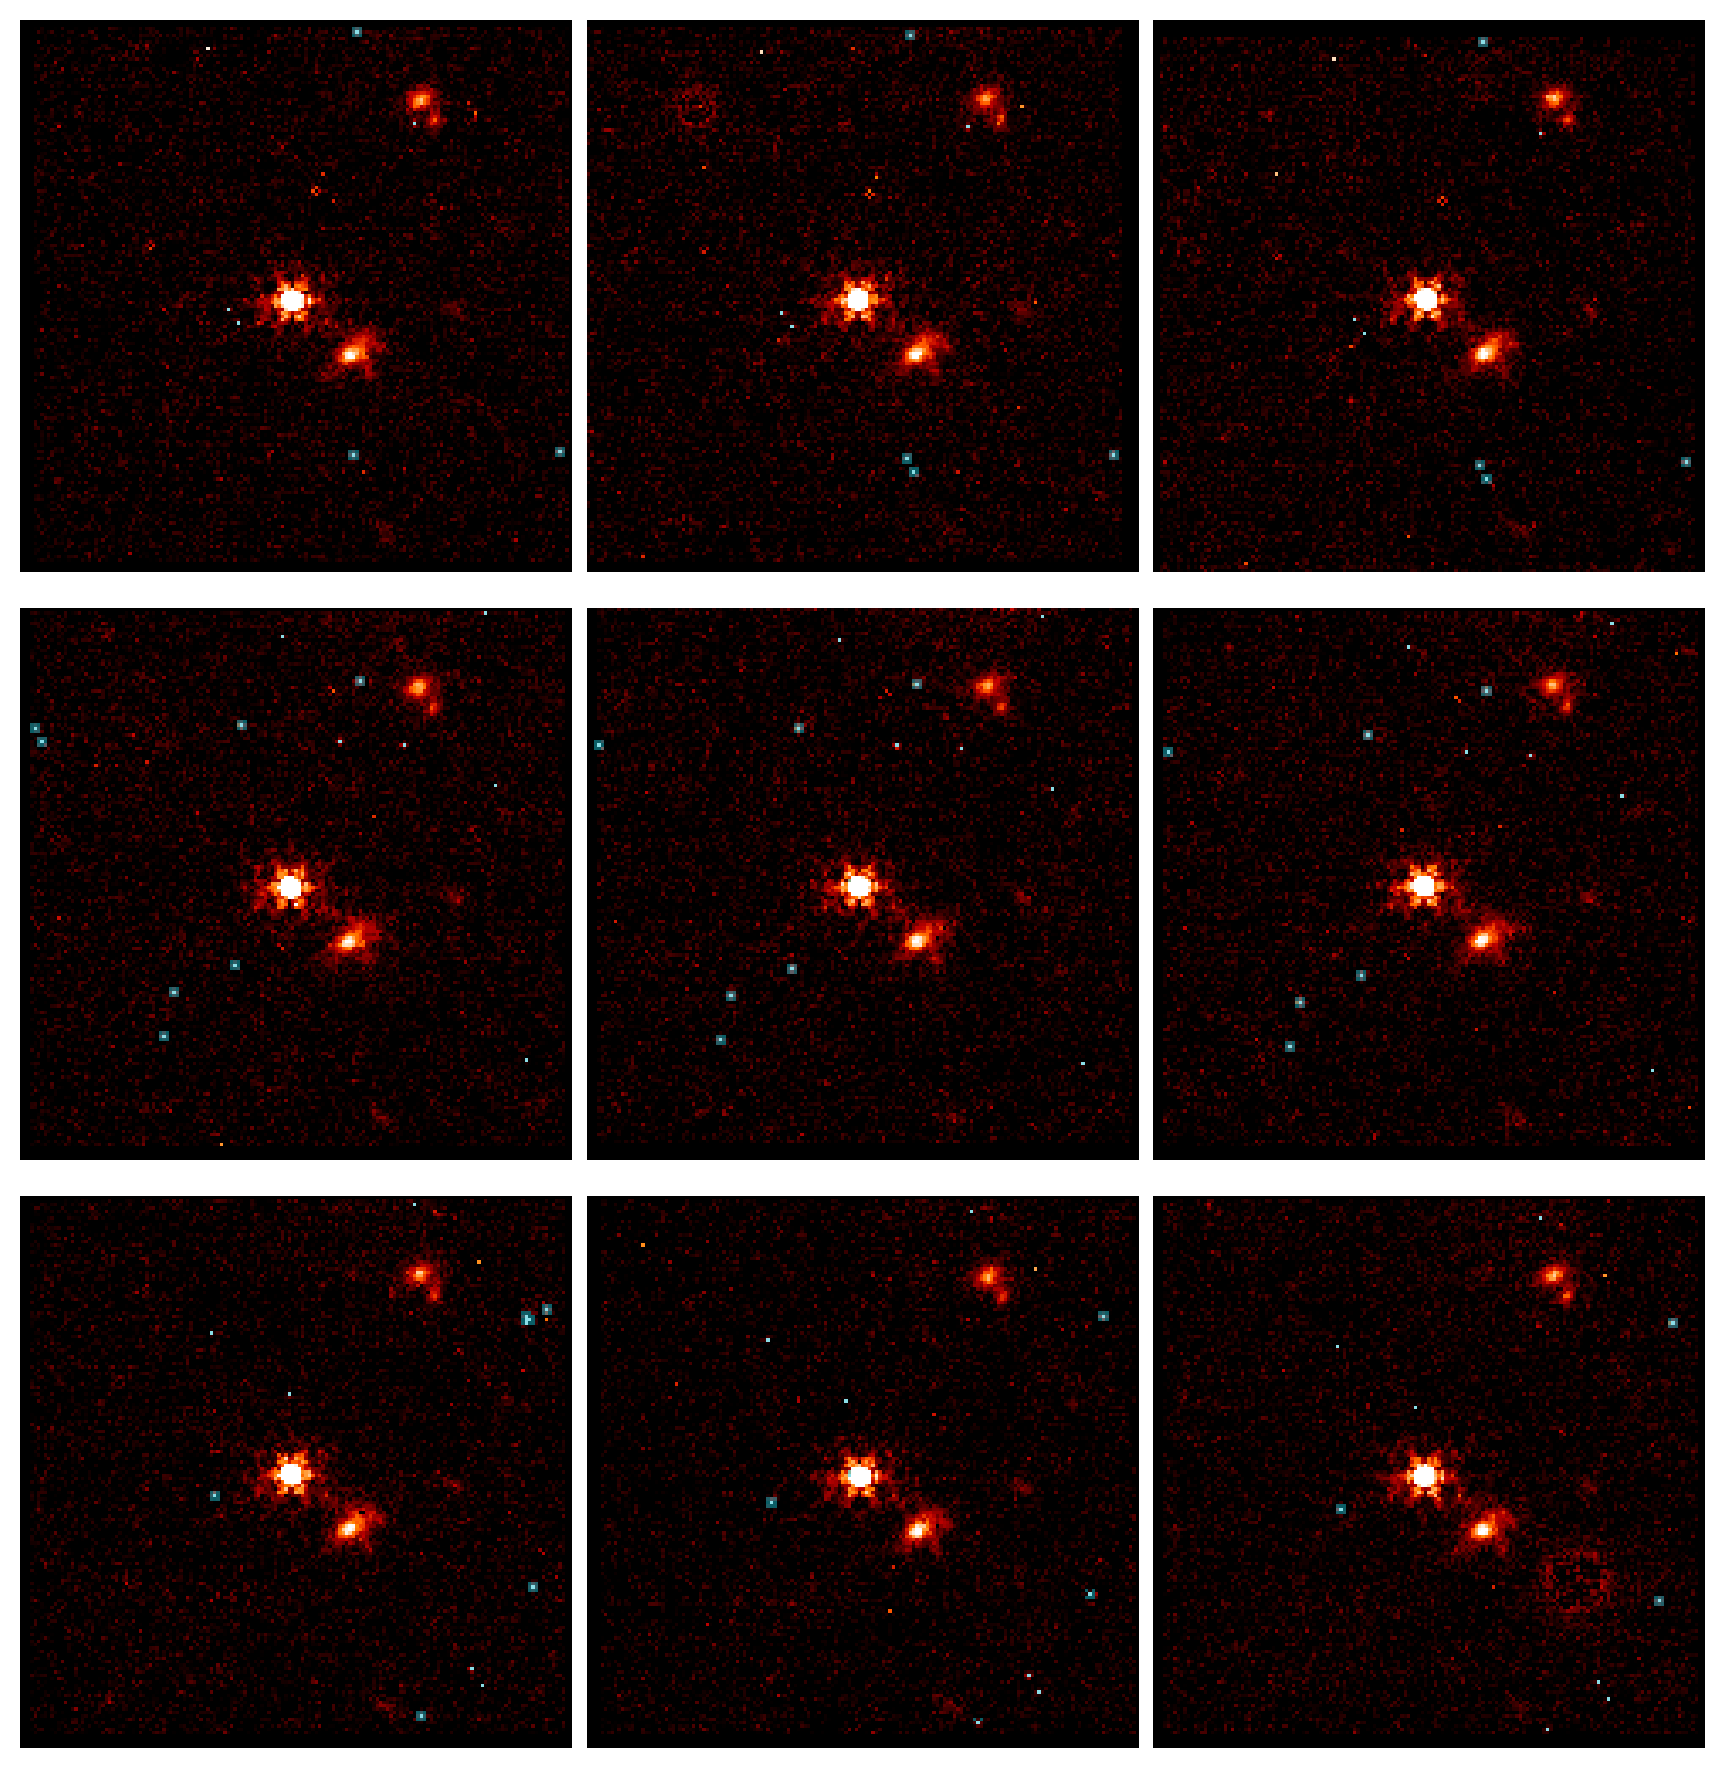

In [20]:
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
axs = axs.flat
for i in range(9): 
    data = aligned_atlas[i]
    mask = masks[i]
    axs[i].imshow(stretch(data), vmin=0, vmax=1)
    axs[i].imshow(mask, cmap=plt.get_cmap('tab10'), alpha=mask*0.5)
    axs[i].grid(False)
    axs[i].axis('off')
plt.tight_layout()
plt.show()

### Coadd Images Using Updated Code

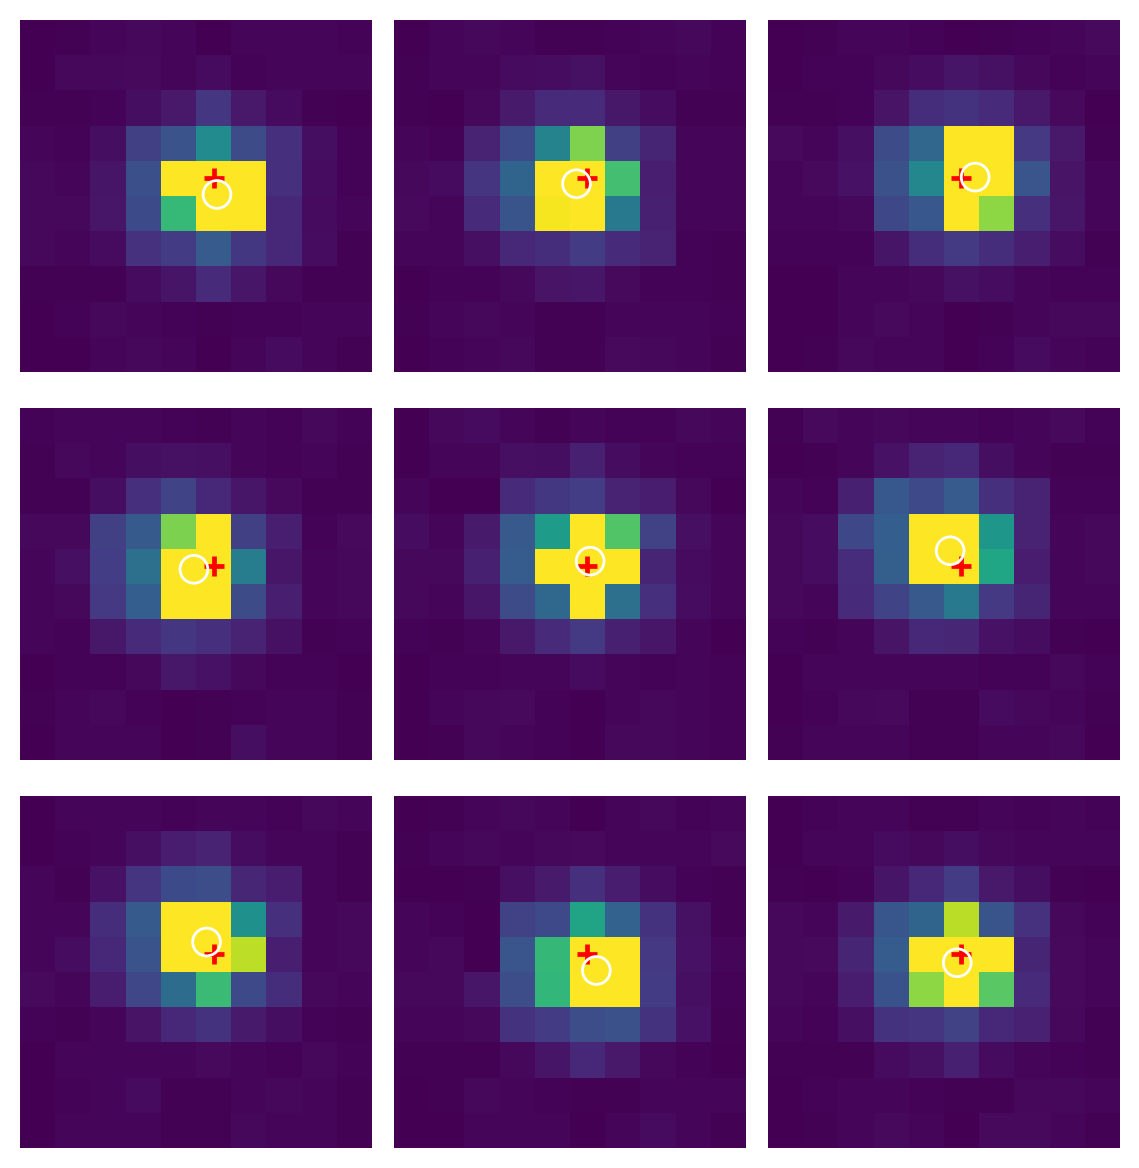

In [25]:
def plot_current_grid(atlas, centers, r_show, markerpos=None, markersize=100):
    cx, cy = centers
    fig, axs = plt.subplots(3, 3, figsize=[6, 6])
    axs = axs.flatten()
    for i in range(9):
        _, _, std = sigma_clipped_stats(atlas[i])
        axs[i].imshow(atlas[i][cx-r_show:cx+r_show, cy-r_show:cx+r_show], 
                        vmin=0, vmax=std*1000, cmap='viridis')
        axs[i].grid(False)
        axs[i].scatter(r_show, r_show, marker='+', c='r', s=50)
        if markerpos is not None:
            axs[i].scatter(markerpos[i][0], markerpos[i][1], 
                           marker='o', c='none', s=markersize, edgecolor='w')
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()


r_show = 5
plot_current_grid(aligned_atlas_masked, centers=(cx, cy), r_show=r_show, 
                    markerpos=centroids+r_show, markersize=100)

[[-0.456  0.096  1.   ]
 [-0.152 -0.311  1.   ]
 [ 0.036  0.395  1.   ]
 [-0.082 -0.559  1.   ]
 [ 0.149  0.077  1.   ]
 [ 0.445 -0.315  1.   ]
 [ 0.352 -0.2    1.   ]
 [-0.457  0.254  1.   ]
 [-0.237 -0.114  1.   ]]


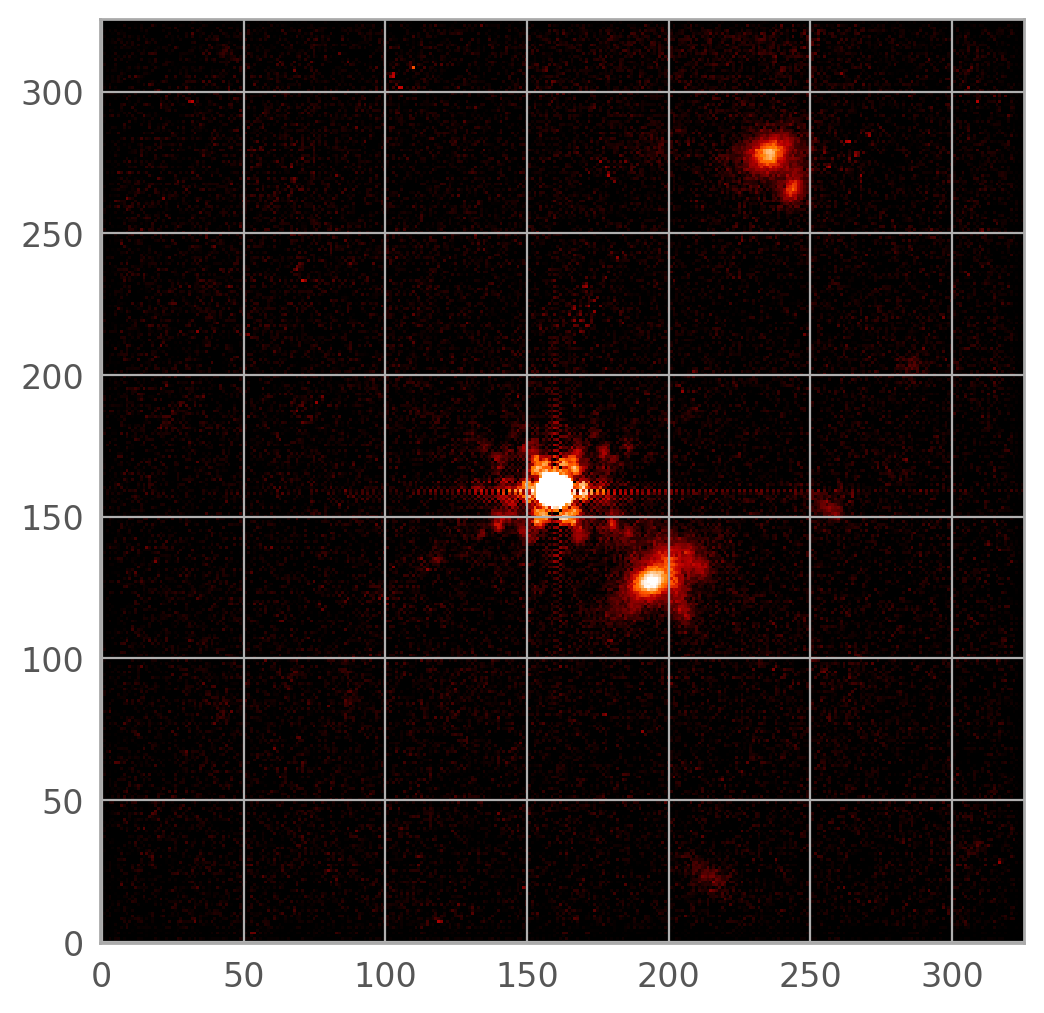

In [24]:
from dither.wrapper import NR_FREQ, NC_FREQ
NSUB = 2


used_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8]

# [y, x, wt]
offsets = np.hstack((centroids[used_indices, 1:2], 
                     centroids[used_indices, 0:1], 
                     [[1]]*len(used_indices)))
# offsets[0, 0] = 0
# offsets[0, 1] = 0
print(offsets)

Atotal = np.zeros((NC_FREQ, NR_FREQ))
for i, j in enumerate(used_indices): 
    data = aligned_atlas_masked[j]
    nx, ny = data.shape
    data_large = np.zeros((NC_FREQ, NR_FREQ))
    data_large[:nx*NSUB:NSUB, :ny*NSUB:NSUB] = data
    A = updated.real2dfft_forward(data_large)
    n = i + 1
    Aphased = updated.phase_shift(A, offsets, n, verbose=False)
    Atotal += Aphased

f = updated.real2dfft_backward(Atotal)

nx, ny = aligned_atlas[0].shape
nx_large = nx*NSUB
ny_large = ny*NSUB
plt.imshow(stretch(f[:nx_large, :ny_large]))
plt.show()

In [19]:
from jwst.datamodels import ImageModel
from astropy.modeling import models
import gwcs
from gwcs import coordinate_frames as cf
from astropy import coordinates as coord

outpath = './dither_image_f250m.fits'
dither_image = f[:nx_large, :ny_large]
app = 0.063 # pixel scale in arcsec / pixel for SW channel

# Build JWST typed fits file
model = ImageModel(data=dither_image)
# ImageModel wcs parameters
model.meta.wcsinfo = {
    'dec_ref': 0., # used in calculating scale of pc
    'ra_ref': 0., # used in calculating scale of pc
    'v3yangle': 0., # used in calculating rotation of pc
    'vparity': 1, # 1 or -1, used in calculating rotation of pc
}
# ImageModel exposure parameters
exposure_attributes = [
    'exposure_time',
    'duration',
    'start_time',
    'end_time',
    'measurement_time',
    'effective_exposure_time',
    'elapsed_exposure_time'
]
for attr in exposure_attributes:
    setattr(model.meta.exposure, attr, 0)
# ImageModel gwcs construction
detector_frame = cf.Frame2D(
    name="detector", axes_names=("x", "y"), unit=(u.pix, u.pix), 
    axes_order=(0, 1)
)
sky_frame = cf.CelestialFrame(
    reference_frame=coord.ICRS(), name='icrs', unit=(u.deg, u.deg), 
    axes_names=('lon', 'lat'), axes_order=(0, 1)
)
pixel_center = models.Shift(offset=-(nx-1)/2, name='crpix1') & \
                models.Shift(offset=-(ny-1)/2, name='crpix2')
pc_rotation_matrix = models.AffineTransformation2D(
    matrix=[[1., 0.], [ 0., 1.]], translation=[0., 0.], 
    name='pc_rotation_matrix'
)
pixel_scale = models.Scale(factor=app/3600., name='cdelt1') & \
                models.Scale(factor=app/3600., name='cdelt2') # deg/pixel
tangent_projection = models.Pix2Sky_Gnomonic()
celestial_rotation = models.RotateNative2Celestial(
    lon=0., lat=0., lon_pole=180.
)
# source_offset = models.Shift(offset=ra_shift, name='source_shift_ra') & \
#                 models.Shift(offset=dec_shift, name='source_shift_dec')
forward_transorm = pixel_center | pc_rotation_matrix | pixel_scale | \
                    tangent_projection | celestial_rotation # | source_offset
gwcs_wcs = gwcs.wcs.WCS(
    forward_transform=forward_transorm,
    input_frame=detector_frame,
    output_frame=sky_frame
)
model.meta.wcs = gwcs_wcs
model.save(outpath)

'./dither_image_f250m.fits'